# Workers productivity

Contenido:
- Analisis de datos de la productividad de trabajadores.
- Modelo predictivo de la productividad de los trabajadores.

Importamos librerias necesarias

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.metrics import accuracy_score,r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error

Leemos nuestros datos

In [2]:
df = pd.read_csv('garments_worker_productivity.csv')

In [3]:
df

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,01/01/2015,1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,01/01/2015,1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,01/01/2015,1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,01/01/2015,1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,01/01/2015,1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,03/11/2015,2,finishing,Wednesday,10,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.628333
1193,03/11/2015,2,finishing,Wednesday,8,0.70,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1194,03/11/2015,2,finishing,Wednesday,7,0.65,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1195,03/11/2015,2,finishing,Wednesday,9,0.75,2.90,NaN,1800,0,0.0,0,0,15.0,0.505889


Atributos del dataset:
1. **date**: Fecha en MM-DD-AAAA
3. **quarter**: Una parte del mes. Un mes se divide en cuatro trimestres
4. **department**: Departamento asociado
2. **day**: Día de la semana
5. **team**: Número de equipo asociado a la instancia
8. **targeted_productivity**: Objetivo de productividad fijado por la autoridad para cada equipo para cada día
9. **smv**: Valor estándar del minuto, es el tiempo asignado a una tarea 
10. **wip**: Trabajos en curso. Incluye el número de artículos sin terminar para los productos 
11. **over_time**: Representa la cantidad de tiempo extra de cada equipo en minutos
12. **incentive**: Representa el importe del incentivo financiero (en BDT) que permite o motiva una determinada acción
13. **idle_time**: La cantidad de tiempo en que la producción se interrumpió debido a varias razones 
14. **idle_men**: El número de trabajadores que estuvieron inactivos debido a la interrupción de la producción
7. **no_of_style_change**: Número de cambios en el estilo de un determinado producto
6. **no_of_workers**: Número de trabajadores en cada equipo
15. **actual_productivity**: Es el porcentaje real de productividad que han aportado los trabajadores. Va de 0 a 1.

# Analisis exploratorio

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   int64  
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

Veamos cuantos valores nulos tenemos

In [5]:
df.isnull().sum()

date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64

Veamos los tipos de departamentos

In [6]:
df['department'].value_counts()

sweing        691
finishing     257
finishing     249
Name: department, dtype: int64

Podemos ver que el mismo departamento por un error en la escritura lo toma como uno diferente

La descripcion nos dice que la productividad va de 0 - 1, veamos si hay valores que se salen de ese rango.

In [7]:
column = df['actual_productivity']
count = column[column > 1].count()
count 

37

## Data cleaning

Ahora fusionemos los dos departamentos de "finishing".

In [8]:
df['department'] = df['department'].apply(lambda x: 'finishing' if x.replace(" ","") == 'finishing' else 'sewing' )

Podemos ver que ahora ya tenemos los departamentos correctos

<AxesSubplot: ylabel='department'>

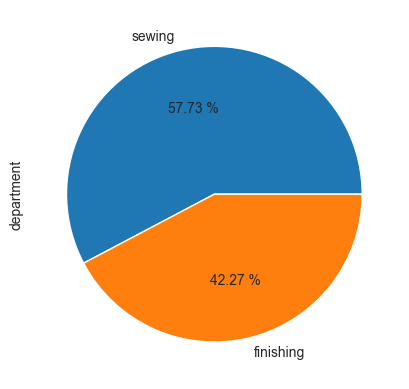

In [9]:
df.department.value_counts().plot.pie(autopct='%.2f %%')

### Saquemos algunas graficas

Comparemos la productividad real y la productividad objetivo para ver el rendimiento de los empleados.

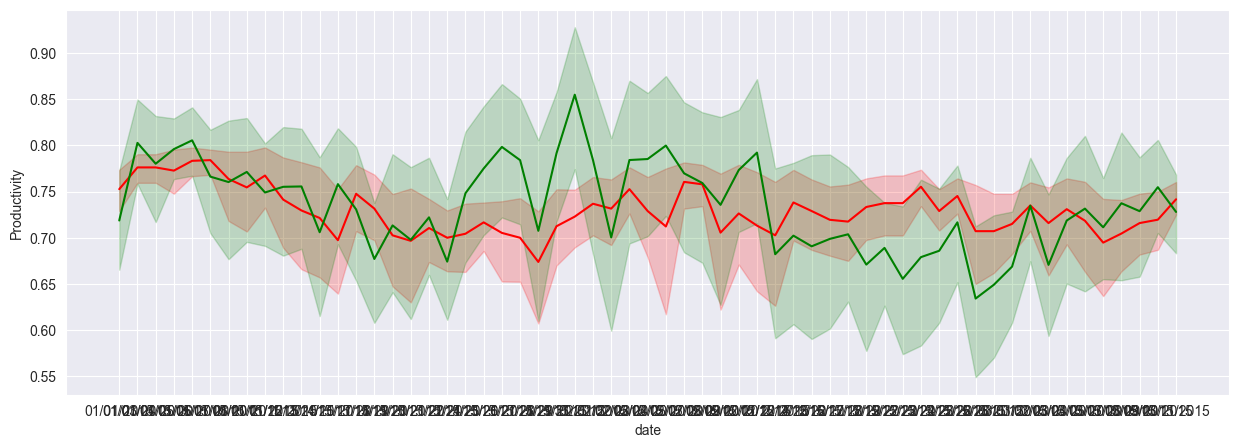

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (15,5))
ax=sns.lineplot(y='targeted_productivity',x='date' ,color = "red", data =df,legend='brief')
ax=sns.lineplot(y= 'actual_productivity',x='date',data=df, color="green", legend = 'brief')
ax.set(ylabel = 'Productivity')
plt.show()

Ahora analicemos si el día concreto de la semana o el equipo o el departamento tiene algún efecto significativo en la productividad.

Productividad en Thursday :  0.7226408815326634
Productividad en Saturday :  0.7519288593743317
Productividad en Sunday :  0.7286041288078818
Productividad en Monday :  0.7354884994170856
Productividad en Tuesday :  0.742700917676617
Productividad en Wednesday :  0.7304619085144229


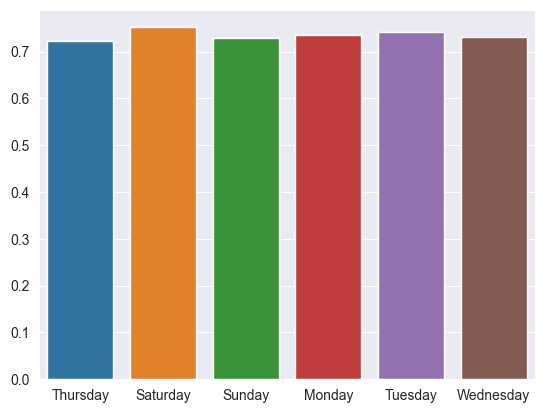

In [11]:
l = []
l1=[]
column_name = "day"
for i in list(df[column_name].unique()):
    print( f"Productividad en {i} : ",df[df[column_name] == i]["actual_productivity"].mean())
    l.append(df[df[column_name] == i]["actual_productivity"].mean())
    l1.append(i)
    dictionary = {"data":l,"keys":l1}
    sns.barplot( x = "keys" , y = "data", data = dictionary)
# plt.savefig('days.png')

Como podemos ver arriba, la productividad no depende del equipo, la categoría, el trimestre o el día.

Vamos a trazar la matriz de correlación para ver la cantidad de correlación -

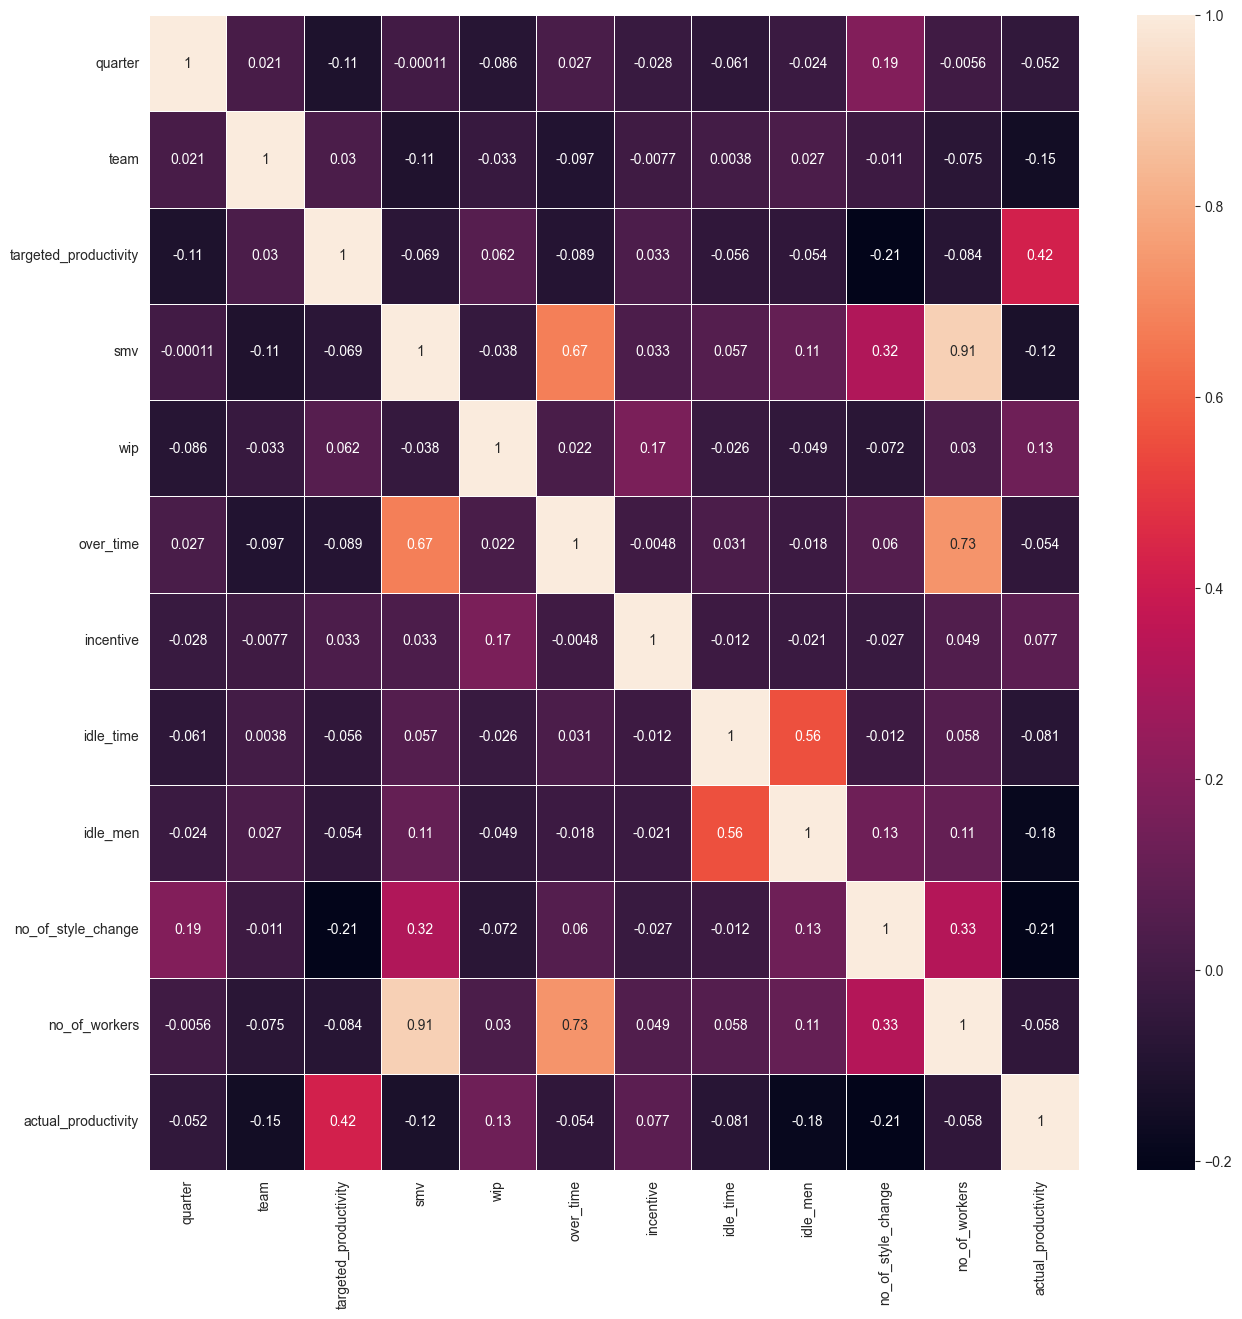

In [12]:
corrMatrix = df.corr()
fig, ax = plt.subplots(figsize=(15,15)) # Sample figsize in inches
sns.heatmap(corrMatrix, annot=True, linewidths=.5, ax=ax)
plt.show()

A partir de estos datos, es evidente que la productividad depende principalmente del objetivo de productividad, ya que el hecho de tener un objetivo motivará e impulsará a los empleados.

## Preparemos los datos finales

Hagamos una limpieza y un preprocesamiento de los datos antes de pasar a la predicción

In [13]:
df['date'] = pd.to_datetime(df['date'])

In [14]:
df.date

0      2015-01-01
1      2015-01-01
2      2015-01-01
3      2015-01-01
4      2015-01-01
          ...    
1192   2015-03-11
1193   2015-03-11
1194   2015-03-11
1195   2015-03-11
1196   2015-03-11
Name: date, Length: 1197, dtype: datetime64[ns]

Así que los datos que tenemos son de 3 meses. 
Optamos por dejar el dia ya que como son pocos meses es suficiente en lugar de la fecha completa.

In [15]:
df['Dia']=df['date'].dt.day
df.drop(['date'],axis=1, inplace=True)

Eliminamos aquello renglones donde la productividad es mayor a 1

In [16]:
df = df.drop(df[df['actual_productivity'] > 1].index)
df

,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,Dia
0,1,sewing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725,1
1,1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500,1
2,1,sewing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1
3,1,sewing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1
4,1,sewing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,2,finishing,Wednesday,10,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.628333,11
1193,2,finishing,Wednesday,8,0.70,3.90,NaN,960,0,0.0,0,0,8.0,0.625625,11
1194,2,finishing,Wednesday,7,0.65,3.90,NaN,960,0,0.0,0,0,8.0,0.625625,11
1195,2,finishing,Wednesday,9,0.75,2.90,NaN,1800,0,0.0,0,0,15.0,0.505889,11


Optamos por quitar los valores donde el "wip" era cero

In [17]:
df = df[df['wip'].notna()]

In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [19]:
df

,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,Dia
0,1,sewing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725,1
2,1,sewing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1
3,1,sewing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1
4,1,sewing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382,1
5,1,sewing,Thursday,7,0.80,25.90,984.0,6720,38,0.0,0,0,56.0,0.800125,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,2,sewing,Wednesday,4,0.75,26.82,1054.0,7080,45,0.0,0,0,59.0,0.750051,11
1188,2,sewing,Wednesday,5,0.70,26.82,992.0,6960,30,0.0,0,1,58.0,0.700557,11
1189,2,sewing,Wednesday,8,0.70,30.48,914.0,6840,30,0.0,0,1,57.0,0.700505,11
1190,2,sewing,Wednesday,6,0.70,23.41,1128.0,4560,40,0.0,0,1,38.0,0.700246,11


### Apliquemos PCA para ver si podemos eliminar variables

En los datos, puedes ver algunas columnas no numéricas. Así que vamos a codificarlas, ya que la mayoría de los algoritmos de aprendizaje automático sólo funcionan con datos numéricos.

In [20]:
#!pip install MultiColumnLabelEncoder

In [21]:
import MultiColumnLabelEncoder

In [22]:
Mcle = MultiColumnLabelEncoder.MultiColumnLabelEncoder()
df = Mcle.fit_transform(df)

In [23]:
# Entrenamiento modelo PCA con escalado de los datos
# ==============================================================================
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(df)

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']

In [24]:
# Se combierte el array a dataframe para añadir nombres a los ejes.
pd.DataFrame(
    data    = modelo_pca.components_,
    columns = df.columns,
    index   = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15']
)

,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,Dia
PC1,2.602825e-01,5.551115e-17,-2.910624e-02,-5.510299e-02,-4.267172e-01,1.632258e-01,-1.310580e-01,-0.015044,-4.451683e-01,1.215320e-01,2.014183e-01,3.330776e-01,1.277330e-01,-5.032865e-01,0.261092
PC2,-2.280127e-01,-5.551115e-17,4.715887e-02,3.980418e-01,-7.257340e-02,-4.406054e-01,-3.106779e-02,-0.403775,-2.375793e-01,1.422207e-01,1.858217e-01,-1.899925e-02,-4.835643e-01,-1.609240e-01,-0.229471
PC3,-5.478164e-01,1.110223e-16,6.011184e-02,-2.125850e-01,-7.091773e-02,2.807662e-01,4.502161e-02,0.141415,-1.452094e-01,2.604074e-01,2.317104e-01,-1.301251e-01,2.693626e-01,-1.426773e-01,-0.541086
PC4,2.010234e-01,-2.775558e-17,-4.119541e-02,5.016257e-03,2.876109e-01,1.652860e-02,-3.560182e-02,-0.069672,2.065804e-01,6.178989e-01,5.970878e-01,-3.617251e-03,5.030081e-02,2.032015e-01,0.209595
PC5,6.188208e-02,-4.163336e-17,-5.735328e-01,1.433531e-01,-2.213351e-01,-1.731634e-01,-3.288008e-02,0.522715,1.858647e-02,1.536367e-01,-1.411726e-02,-4.795838e-01,-1.327861e-01,-1.415195e-01,0.039800
PC6,7.542697e-02,3.230922e-17,2.118301e-01,6.815268e-02,-1.925877e-01,-1.055702e-01,9.298748e-01,0.087311,5.550043e-02,8.069640e-02,4.272316e-02,-1.999484e-02,3.604882e-02,-7.382938e-02,0.075504
PC7,-6.623772e-02,2.255141e-17,-7.743037e-01,-1.685197e-01,1.067627e-01,3.239279e-02,2.817106e-01,-0.299892,-2.442091e-02,-9.043213e-02,2.233232e-02,3.877298e-01,2.001088e-02,8.356575e-02,-0.137596
PC8,4.162167e-02,-7.632783e-17,7.552706e-02,-8.453223e-01,-1.723864e-01,-2.549075e-01,-1.286098e-02,-0.123535,7.398790e-03,1.077653e-01,-3.447583e-02,-1.657856e-01,-3.532066e-01,1.304045e-02,0.051047
PC9,1.324053e-01,-5.551115e-17,-4.557594e-02,-1.683436e-02,3.822568e-01,5.095410e-01,1.653635e-01,-0.239279,-3.147760e-01,-1.647977e-01,6.126545e-02,-4.967181e-01,-2.514812e-01,-1.941996e-01,0.109888
PC10,-3.492195e-02,-1.040834e-17,8.493034e-02,-1.144522e-01,4.627313e-01,-1.709691e-01,5.554979e-02,0.584458,-2.951892e-01,-2.094784e-01,2.425239e-01,3.436646e-01,-2.821828e-01,-4.320519e-02,-0.031702


----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[1.99038100e-01 1.51006855e-01 1.44109190e-01 9.93386151e-02
 8.23736142e-02 7.03364021e-02 6.56509060e-02 5.01488696e-02
 4.22054135e-02 3.11149997e-02 3.03213069e-02 2.30394799e-02
 9.65109817e-03 1.66514950e-03 1.34010069e-33]


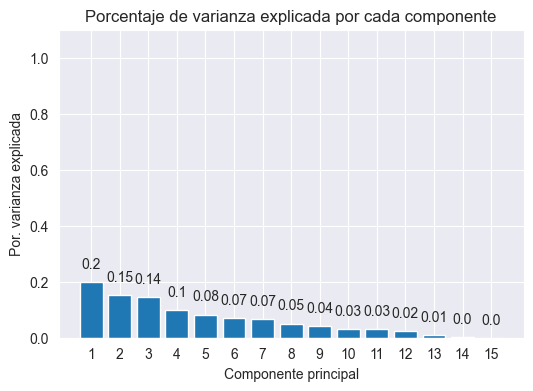

In [25]:
# Porcentaje de varianza explicada por cada componente
# ==============================================================================
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(modelo_pca.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,
    height = modelo_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(df.columns)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

In [26]:
df.drop(['Dia'],axis=1, inplace=True)

### Cambiando rang de los datos (nombre por cambiar)

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#scaler = StandardScaler()
scaler = MinMaxScaler()


# standarizing data
scaled_data = scaler.fit_transform(df)

# creating dataframe with standarized features
scaled_df = pd.DataFrame(scaled_data, index=df.index, columns=df.columns)


In [28]:
scaled_df

,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,0.00,0.0,0.0,0.636364,1.000000,0.361941,0.047631,0.273148,0.867257,0.0,0.0,0.0,0.523810,0.922654
2,0.00,0.0,0.0,0.909091,1.000000,0.030555,0.041575,0.141204,0.442478,0.0,0.0,0.0,0.071429,0.739753
3,0.00,0.0,0.0,1.000000,1.000000,0.030555,0.041575,0.141204,0.442478,0.0,0.0,0.0,0.071429,0.739753
4,0.00,0.0,0.0,0.454545,1.000000,0.356100,0.050314,0.074074,0.442478,0.0,0.0,0.0,0.476190,0.739507
5,0.00,0.0,0.0,0.545455,1.000000,0.356100,0.042267,0.259259,0.336283,0.0,0.0,0.0,0.476190,0.739171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,0.25,0.0,1.0,0.272727,0.931507,0.376769,0.045295,0.273148,0.398230,0.0,0.0,0.0,0.523810,0.673825
1188,0.25,0.0,1.0,0.363636,0.863014,0.376769,0.042613,0.268519,0.265487,0.0,0.0,0.5,0.507937,0.609236
1189,0.25,0.0,1.0,0.636364,0.863014,0.458998,0.039239,0.263889,0.265487,0.0,0.0,0.5,0.492063,0.609169
1190,0.25,0.0,1.0,0.454545,0.863014,0.300157,0.048497,0.175926,0.353982,0.0,0.0,0.5,0.190476,0.608831


In [29]:
# x = df.drop(['actual_productivity'],axis=1)
# y = df['actual_productivity']

x = scaled_df.drop(['actual_productivity'],axis=1)
y = scaled_df['actual_productivity']

## Prediciendo la productividad

Antes de tratar de predecir, vamos a preparar los datos de entrenamiento y de prueba

In [30]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y,train_size=0.8,random_state=0)

Los algoritmos que implementaremos para ver cual se adapta mejor a los datos son los siguientes:

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

Funcion para obtener algunas metricas de los algoritmos con nuestros datos.

In [32]:
def impresionResultados(y_test, pred6):
    print("test_MSE:",mean_squared_error(y_test, pred6))
    print("test_MAE:",mean_absolute_error(y_test, pred6))
    print("R2_score:{}".format(r2_score(y_test, pred6)))

- LinearRegression

In [33]:
model_lr=LinearRegression()

model_lr.fit(x_train,y_train)
pred_test=model_lr.predict(x_test)
impresionResultados(y_test, pred_test)

test_MSE: 0.00866434530149681
test_MAE: 0.05663832062523201
R2_score:0.7224513311390679


- Random Forest Regressor

In [34]:
model_rfe = RandomForestRegressor(n_estimators=200,max_depth=5)

model_rfe.fit(x_train, y_train)
pred = model_rfe.predict(x_test)
impresionResultados(y_test, pred)

test_MSE: 0.007555257661062146
test_MAE: 0.04688286388399012
R2_score:0.757979208611769


- XGBoost

In [35]:
model_xgb = xgb.XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1)

model_xgb.fit(x_train, y_train)
pred3=model_xgb.predict(x_test)
impresionResultados(y_test, pred3)

test_MSE: 0.007201652759244536
test_MAE: 0.04389890368060793
R2_score:0.769306385263561


- SVR

In [36]:
model_svr = SVR(kernel='rbf', C=10, epsilon=0.00001) # set kernel and hyperparameters

svr = model_svr.fit(x_train, y_train)
pred4 = model_svr.predict(x_test)
impresionResultados(y_test, pred4)

test_MSE: 0.010240964384855989
test_MAE: 0.05116810881354719
R2_score:0.6719468195273841


- Lasso

In [37]:
las_reg = Lasso()

las_reg.fit(x_train, y_train)
pred5 = las_reg.predict(x_test)
impresionResultados(y_test, pred5)

test_MSE: 0.03164271743628495
test_MAE: 0.13498817449883607
R2_score:-0.013624664989551283


- Ridge

In [40]:
rid_reg = Ridge()

rid_reg.fit(x_train, y_train)
pred6 = rid_reg.predict(x_test)
impresionResultados(y_test, pred6)

test_MSE: 0.008953554684463728
test_MAE: 0.057980973260595446
R2_score:0.7131869636108379


- Decision Tree Regressor

In [39]:
dt_regressor = DecisionTreeRegressor(random_state = 0)

dt_regressor.fit(x_train,y_train)
pred7 = dt_regressor.predict(x_test)
impresionResultados(y_test, pred7)


test_MSE: 0.007128353925263042
test_MAE: 0.035135291620575444
R2_score:0.7716543980784598
